In [23]:
import os
import torch
import pretty_midi as pm
import matplotlib.pyplot as plt
import seaborn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from numpy import *
from numpy.linalg import norm
import librosa.display

from scipy.io.wavfile import write
from ec2vae.model import EC2VAE

if not os.path.exists('./demo'):
    os.mkdir('./demo')
    
if not os.path.exists('./results'):
    os.mkdir('./results')

In [7]:
# initialize the model
ec2vae_model = EC2VAE.init_model()

# load model parameter
ec2vae_param_path = './ec2vae/model_param/ec2vae-v1.pt'
ec2vae_model.load_model(ec2vae_param_path)

In [10]:
def make_notes(midi_nums):
    continuation = [128 for i in range(7 if len(midi_nums) == 4 else 3)]
    out = []
    for num in midi_nums:
        out += [num] + continuation
    return out

def note_array_to_onehot(note_array):
    pr = np.zeros((len(note_array), 130))
    pr[np.arange(0, len(note_array)), note_array.astype(int)] = 1.
    return pr

def slerp(p0, p1, t):
    omega = arccos(dot(p0/norm(p0), p1/norm(p1)))
    so = sin(omega)
    return sin((1.0-t)*omega) / so * p0 + sin(t*omega)/so * p1

def interpolate(pA, pB):
    pA = pA.cpu().numpy().squeeze(0)
    pB = pB.cpu().numpy().squeeze(0)
    ps = array([slerp(pA, pB, t) for t in intervals])
    return ps

def generate_midi(mel_notes):
    midi = pm.PrettyMIDI()
    ins1 = pm.Instrument(0)
    ins1.notes = mel_notes
    midi.instruments.append(ins1)
    return midi 

def save_midi_as_wav(fn, midi):
    audio = midi.synthesize()
    write(fn, 44100, audio)

def plot_piano_roll(midi, start_pitch, end_pitch, fs=100):
    librosa.display.specshow(midi.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pm.note_number_to_hz(start_pitch))

def repeat_4_notes(pred):
    stripped_notes = [pred[8*i:8*i+4] for i in range(4)]
    stripped_notes = list(np.concatenate(stripped_notes))
    return np.array(stripped_notes*2)

## 1. Inference interpolated latents

In [11]:
sample_dict = {}

f = open('stimuli.txt', 'r')
lines = f.readlines()

set_num = 0
sample_num = 0

for line in lines:
    midi_nums = list(map(int, line.strip('[]\n').split(' ')))
    sample_num = sample_num % 3 + 1
    if sample_num == 1:
        set_num = set_num % 4 + 1
    label = f'{len(midi_nums)}-{set_num}-{sample_num}'
    sample_dict[label] = midi_nums

sample_dict

{'4-1-1': [60, 65, 64, 67],
 '4-1-2': [60, 55, 53, 52],
 '4-1-3': [65, 76, 70, 80],
 '4-2-1': [60, 67, 65, 64],
 '4-2-2': [60, 52, 57, 55],
 '4-2-3': [56, 69, 68, 64],
 '4-3-1': [60, 67, 64, 67],
 '4-3-2': [60, 53, 55, 52],
 '4-3-3': [66, 76, 71, 77],
 '4-4-1': [60, 67, 69, 64],
 '4-4-2': [60, 52, 53, 55],
 '4-4-3': [70, 75, 76, 71],
 '8-1-1': [60, 62, 60, 67, 65, 67, 65, 72],
 '8-1-2': [72, 71, 67, 60, 69, 67, 65, 57],
 '8-1-3': [61, 62, 60, 66, 63, 65, 64, 70],
 '8-2-1': [60, 72, 71, 67, 69, 81, 79, 76],
 '8-2-2': [72, 62, 67, 59, 64, 57, 60, 55],
 '8-2-3': [66, 77, 76, 70, 71, 82, 81, 75],
 '8-3-1': [64, 72, 67, 60, 62, 71, 65, 59],
 '8-3-2': [72, 67, 64, 67, 74, 71, 65, 71],
 '8-3-3': [67, 78, 72, 61, 64, 74, 68, 62],
 '8-4-1': [72, 69, 65, 60, 69, 64, 60, 57],
 '8-4-2': [60, 69, 65, 72, 64, 72, 69, 76],
 '8-4-3': [75, 69, 66, 59, 70, 64, 61, 55]}

In [12]:
# Interpolation intervals
intervals = [0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1]

/tmp/ipykernel_564571/1590239393.py:36: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(midi.get_piano_roll(fs)[start_pitch:end_pitch],


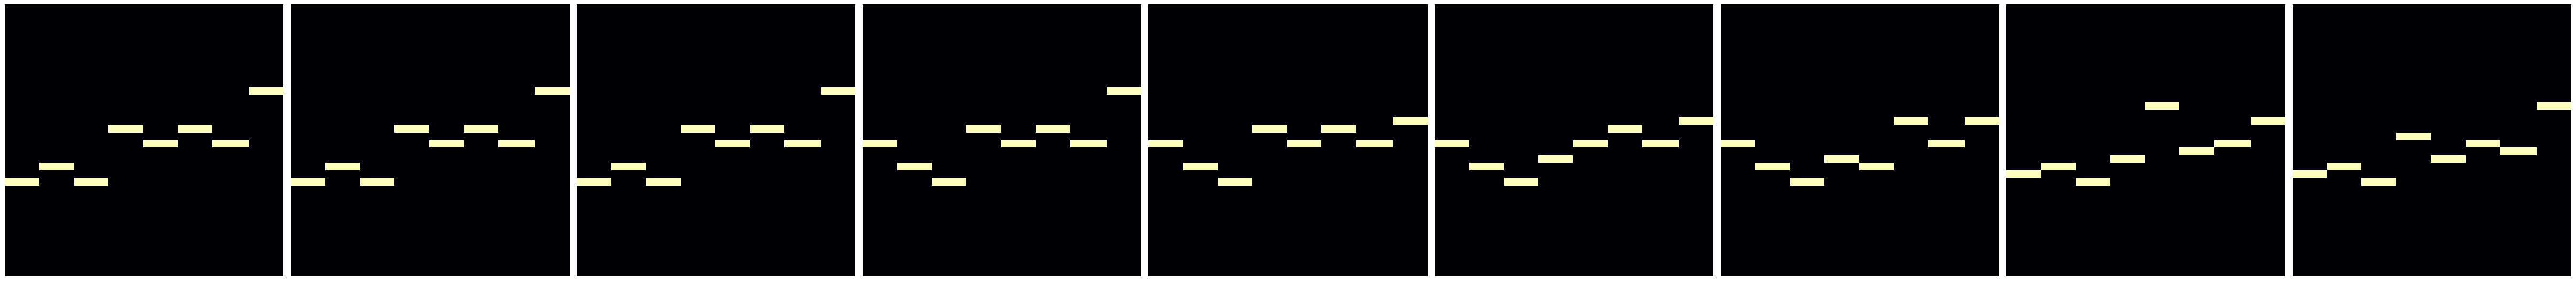

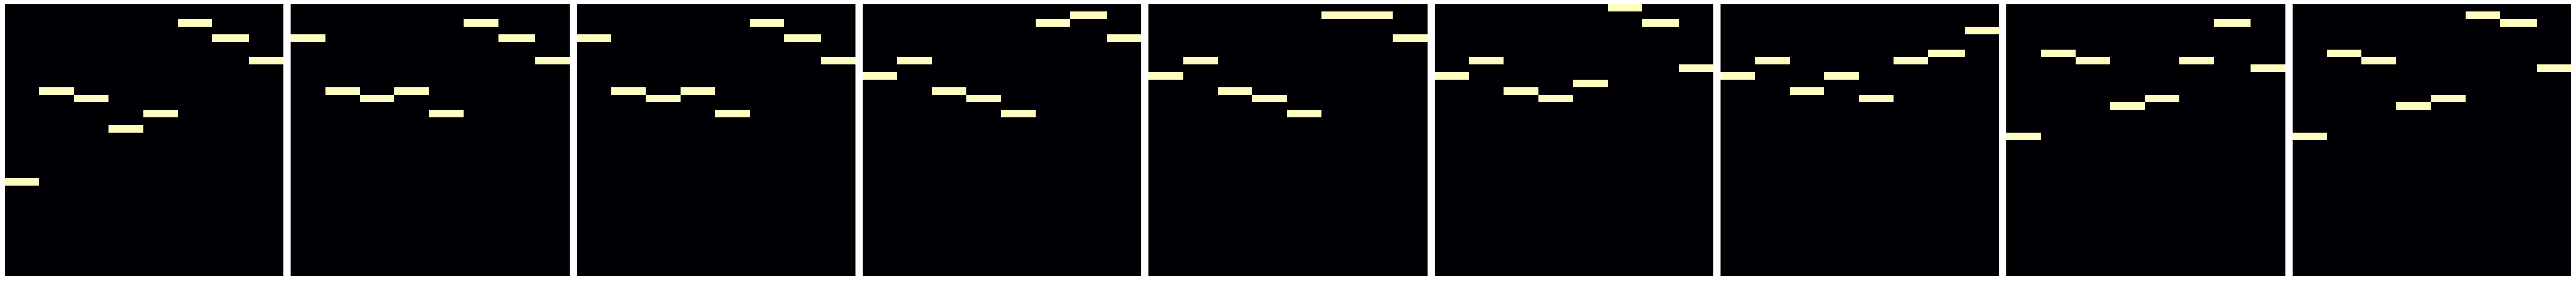

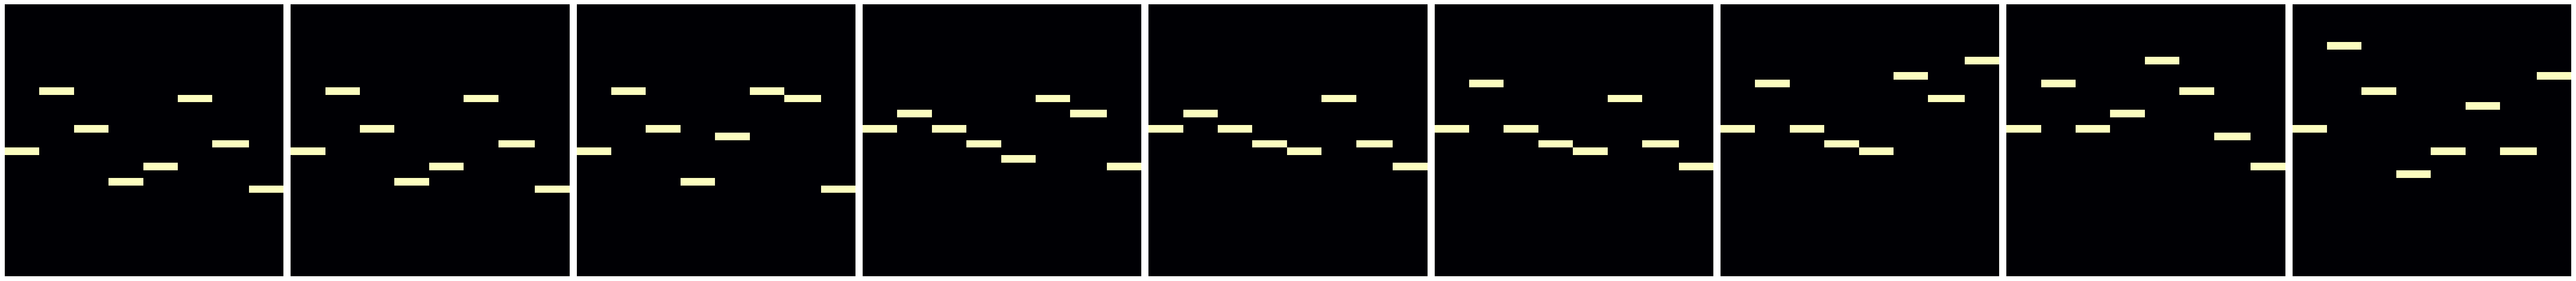

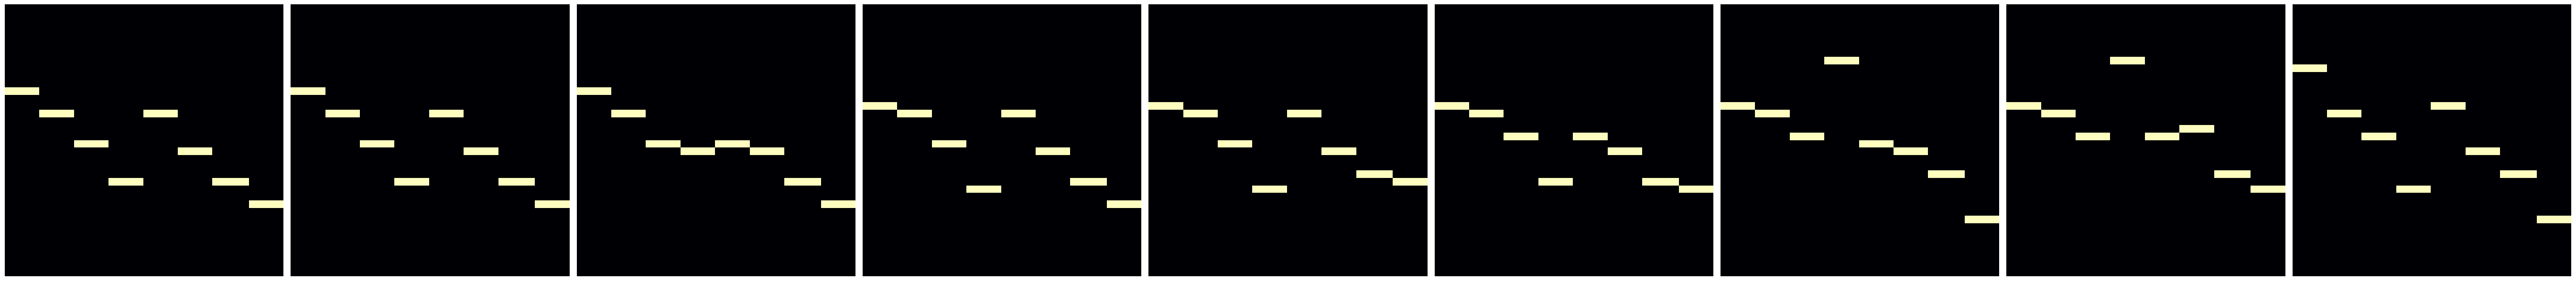

In [13]:
# Create Samples
import enum

note_num = 8
axis_name = ['C', 'T']

for set_idx in range(1, 5):
    x1 = np.array(make_notes(sample_dict[f'{note_num}-{set_idx}-1']))
    x2 = np.array(make_notes(sample_dict[f'{note_num}-{set_idx}-2']))
    x3 = np.array(make_notes(sample_dict[f'{note_num}-{set_idx}-3']))

    pr1 = note_array_to_onehot(x1)
    pr2 = note_array_to_onehot(x2)
    pr3 = note_array_to_onehot(x3)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    pr1 = torch.from_numpy(pr1).float().to(device).unsqueeze(0)
    pr2 = torch.from_numpy(pr2).float().to(device).unsqueeze(0)
    pr3 = torch.from_numpy(pr3).float().to(device).unsqueeze(0)

    # no chord
    c3 = np.zeros((32, 12))
    c3 = torch.from_numpy(c3).float().to(device).unsqueeze(0)

    # encode melody and no chord
    zp1, zr1 = ec2vae_model.encoder(pr1, c3)
    zp2, zr2 = ec2vae_model.encoder(pr2, c3)
    zp3, zr3 = ec2vae_model.encoder(pr3, c3)

    from1to2 = list(zip(interpolate(zp1, zp2), interpolate(zr1, zr2)))
    from1to3 = list(zip(interpolate(zp1, zp3), interpolate(zr1, zr3)))
    
    plt.figure(figsize=(54, 6))

    for axis, result in enumerate([from1to2, from1to3]):
        for i, (zp, zr) in enumerate(result):
            # Generate midi
            zp = torch.from_numpy(zp).float().to(device).unsqueeze(0)
            zr = torch.from_numpy(zr).float().to(device).unsqueeze(0)
            pred = ec2vae_model.decoder(zp, zr, c3)
            pred = pred.squeeze(0).cpu().numpy()

            # 4개 노트일 때 두번 반복으로 바꿔주기
            # if note_num == 4:
            #     pred = repeat_4_notes(pred)
            
            notes = ec2vae_model.__class__.note_array_to_notes(pred, bpm=350, start=0.)
            midi = generate_midi(notes)

            # Plot the notes
            plt.subplot(1, 9, i+1)
            plt.axis('off')
            plot_piano_roll(midi, 48, 84)

            # Save as wav
            save_midi_as_wav(f'./demo/{note_num}-{set_idx}-{axis_name[axis]}-{intervals[i]}.wav', midi)

        plt.tight_layout()
        plt.savefig(f'./demo/{note_num}-{set_idx}-{axis_name[axis]}.png')

## 2. Calculate Similarity
### 2.1 edit distance & Tversky distance

In [21]:
import py_stringmatching as ps

edit = ps.similarity_measure.levenshtein.Levenshtein() # edit.get_sim_score(pivot, pred)
# Tversky = ps.similarity_measure.tversky_index.TverskyIndex() #Tversky.get_sim_score(pivot, pred)

In [20]:
# Get computational distance
import enum

for set_idx in range(1, 5):
    
    x1 = np.array(make_notes(sample_dict[f'{note_num}-{set_idx}-1']))
    x2 = np.array(make_notes(sample_dict[f'{note_num}-{set_idx}-2']))
    x3 = np.array(make_notes(sample_dict[f'{note_num}-{set_idx}-3']))

    pr1 = note_array_to_onehot(x1)
    pr2 = note_array_to_onehot(x2)
    pr3 = note_array_to_onehot(x3)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    pr1 = torch.from_numpy(pr1).float().to(device).unsqueeze(0)
    pr2 = torch.from_numpy(pr2).float().to(device).unsqueeze(0)
    pr3 = torch.from_numpy(pr3).float().to(device).unsqueeze(0)

    # no chord
    c3 = np.zeros((32, 12))
    c3 = torch.from_numpy(c3).float().to(device).unsqueeze(0)

    # encode melody and no chord
    zp1, zr1 = ec2vae_model.encoder(pr1, c3)
    zp2, zr2 = ec2vae_model.encoder(pr2, c3)
    zp3, zr3 = ec2vae_model.encoder(pr3, c3)

    from1to2 = list(zip(interpolate(zp1, zp2), interpolate(zr1, zr2)))
    from1to3 = list(zip(interpolate(zp1, zp3), interpolate(zr1, zr3)))
    
    corpus = []
    for axis, result in enumerate([from1to2, from1to3]):
        pivot = None
        distances = []
        for i, (zp, zr) in enumerate(result):
            # Generate midi
            zp = torch.from_numpy(zp).float().to(device).unsqueeze(0)
            zr = torch.from_numpy(zr).float().to(device).unsqueeze(0)
            pred = ec2vae_model.decoder(zp, zr, c3)
            pred = pred.squeeze(0).cpu().numpy()
            pred = list(pred)
            
            if i == 0: 
                pivot = pred
                continue
                
            distance = edit.get_sim_score(pivot, pred)
            # distance = Tversky.get_sim_score(pivot, pred)
            distances.append(round(distance, 4))
            pivot = pred
            
        print(f'{set_idx}-{axis_name[axis]}: {distances}')

1-C: [1.0, 1.0, 0.9231, 0.9231, 1.0, 1.0, 0.8571, 1.0]
1-T: [1.0, 1.0, 1.0, 0.8333, 0.9231, 0.9231, 0.8, 0.8889]
2-C: [1.0, 0.7778, 0.625, 0.9333, 0.875, 0.8571, 0.8571, 0.9412]
2-T: [0.875, 1.0, 0.875, 0.9412, 0.5882, 0.625, 0.5333, 0.9412]
3-C: [1.0, 0.5, 0.9333, 0.6667, 0.7692, 0.7143, 0.8, 1.0]
3-T: [1.0, 0.8235, 0.4, 0.8571, 0.8571, 0.8, 0.5, 0.375]
4-C: [1.0, 1.0, 0.8571, 0.8, 0.9333, 0.7143, 1.0, 1.0]
4-T: [1.0, 1.0, 0.8, 0.875, 0.8, 0.625, 0.7059, 0.7059]


## 3. Inference & Caculate similarity with respect to AI and Composer input

In [39]:
sample_dict = {}
f = open(f'./results/ai_midi.txt', 'r')
lines = f.readlines()

for line in lines:
    value = line.split(":")[1].strip(' []\n').split(', ')
    key = line.split(":")[0].strip()
    sample_dict[key] = value
    
f = open(f'./results/composer_midi.txt', 'r')
lines = f.readlines()

for line in lines:
    value = line.split(":")[1].strip(' []\n').split(', ')
    key = line.split(":")[0].strip()
    added_num = int(key[-1]) + 5
    sample_dict[key[:-1] + str(added_num)] = value

In [36]:
# Change this value to check the specific set
set_num = 3

# Change this value to change similarity methods. 0 = edit distance, 1 = tfidf, 2 = Tversky
d_type_idx = 0

Save in ./results/edit_distance


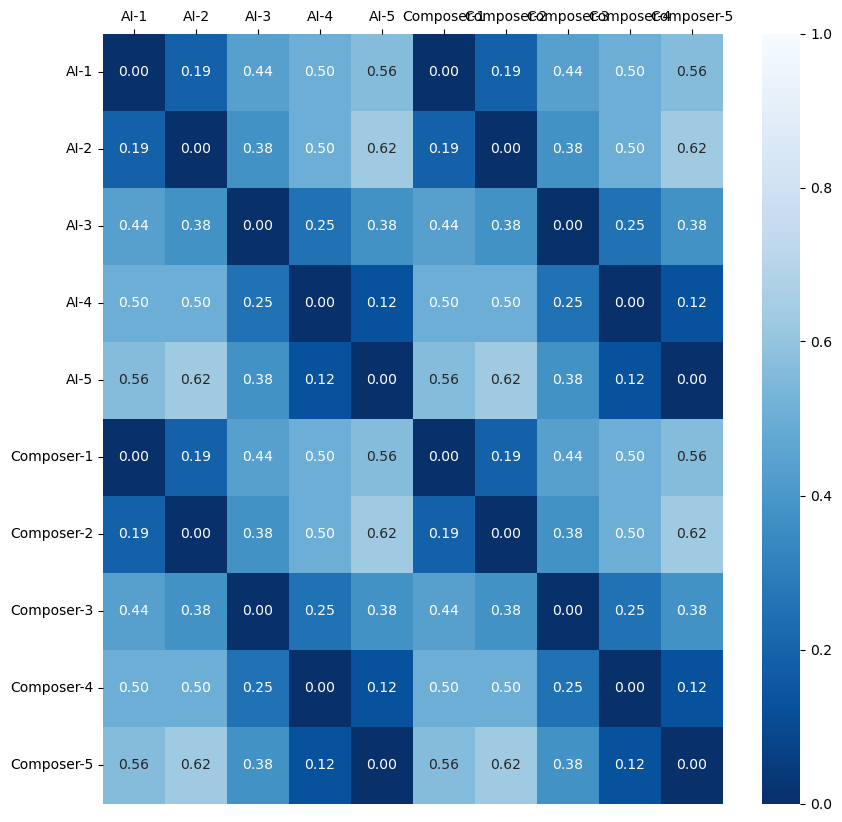

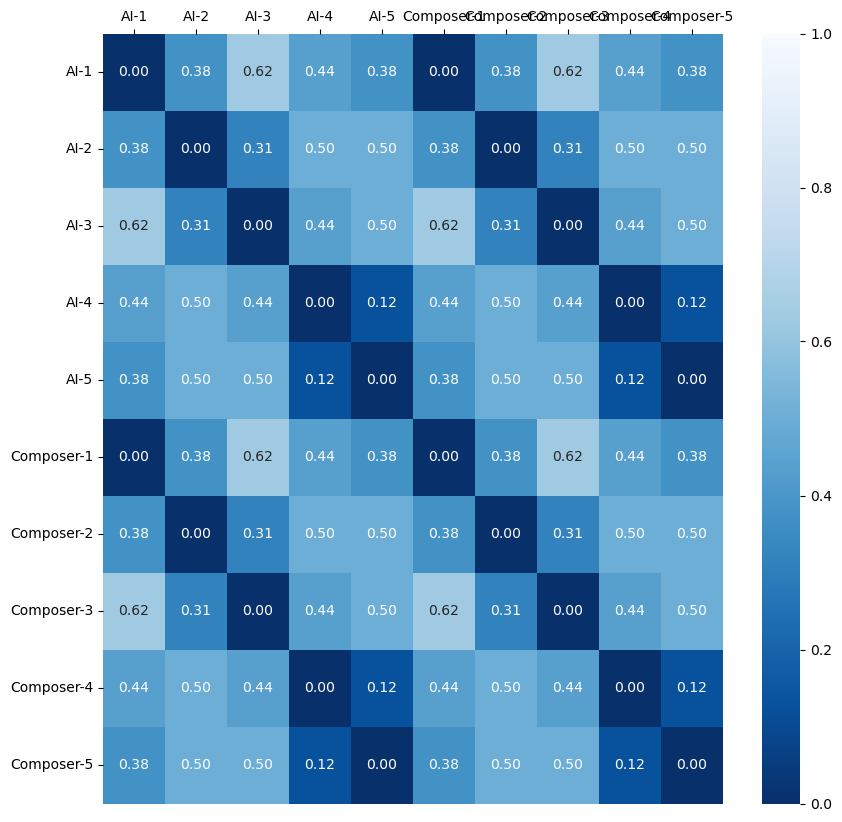

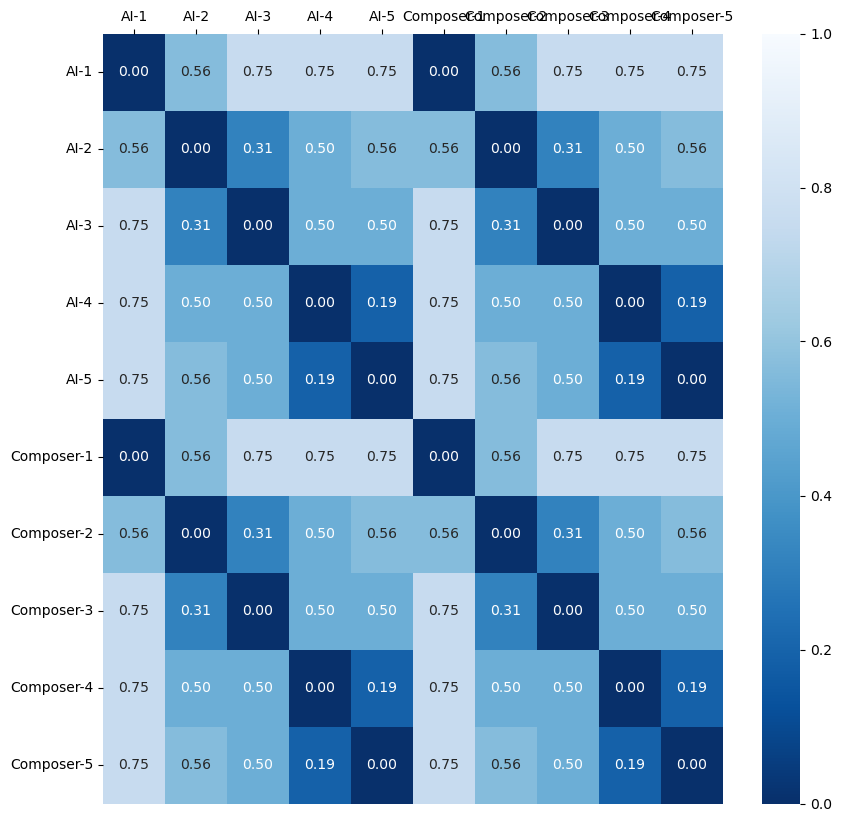

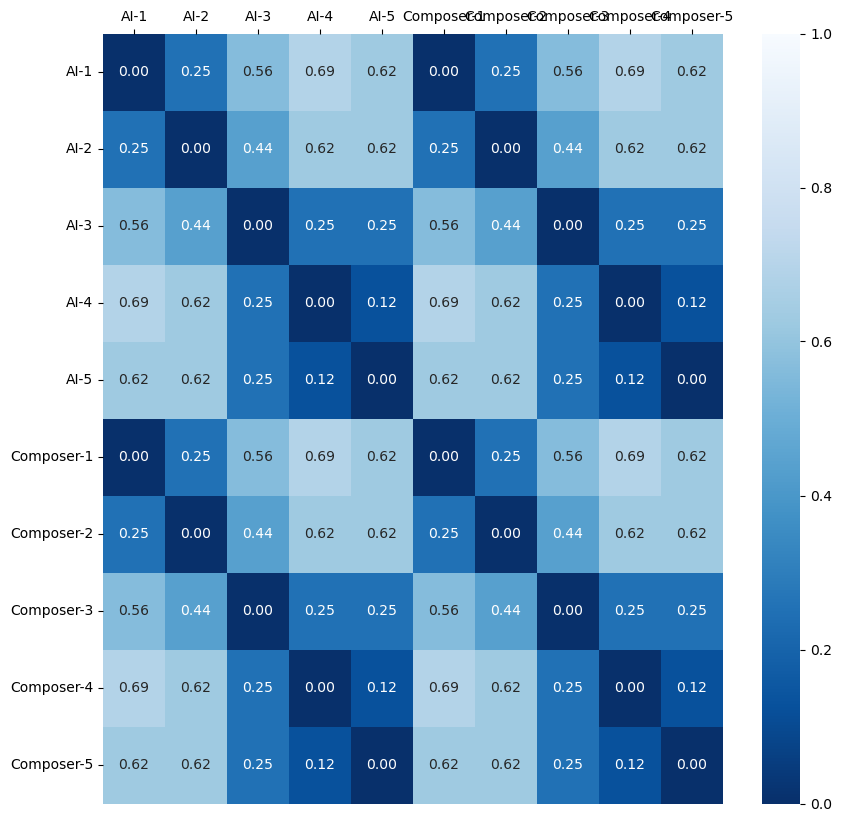

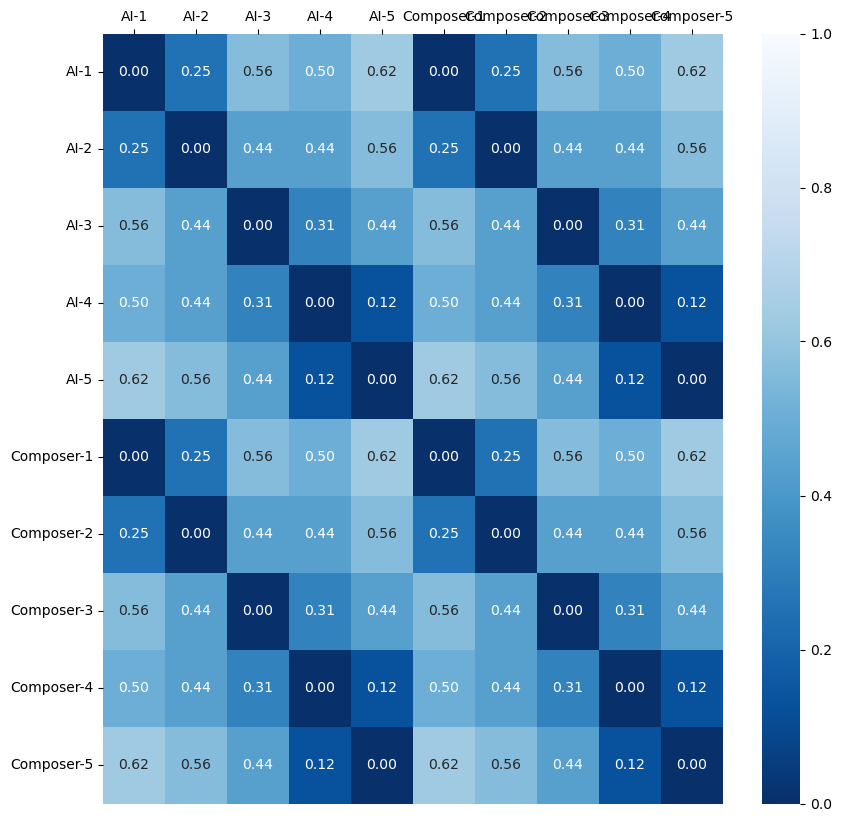

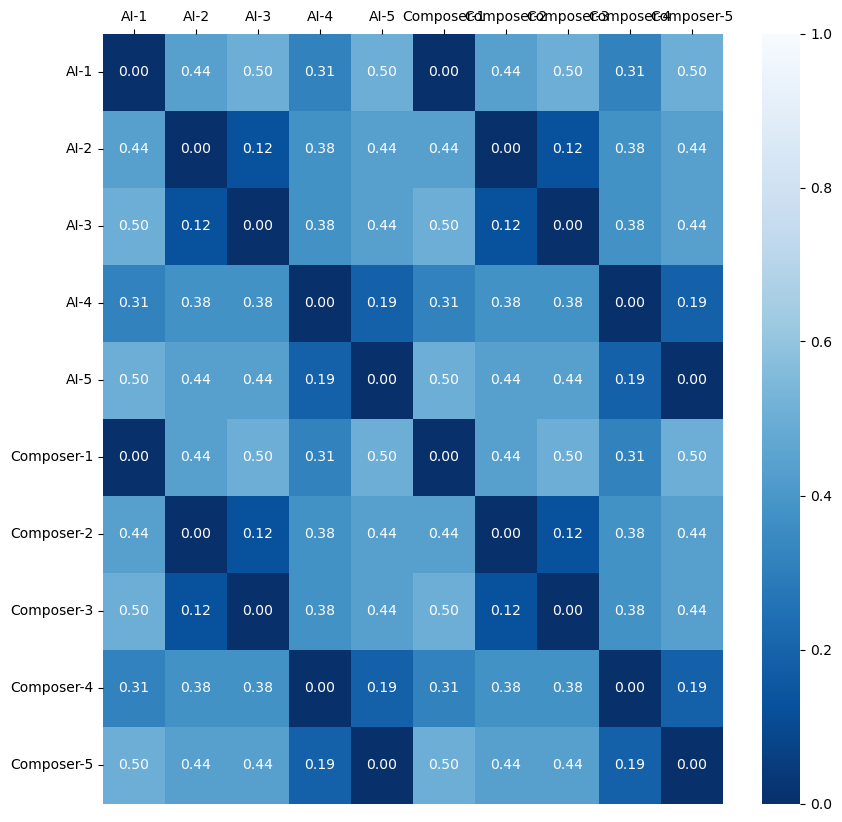

In [42]:
# Get computational distance with the completed files
d_types = ['edit_distance', 'tfidf', 'Tversky']
d_type = ['edit_distance', 'tfidf', 'Tversky'][d_type_idx]
axiss = ['C', 'T']

print(f'Save in ./results/{d_type}')
os.makedirs(f'./results/{d_type}/', exist_ok=True)

for set_idx in range(set_num):
    corpus = []
    for axis in axiss:
        distances = np.zeros((10, 10))
        
        if d_type == 'tfidf':
            for i in range(5):
                a = sample_dict[f'{set_idx+1}-{axis}-{i+1}']
                corpus.append(a)
            TfIdf = ps.similarity_measure.tfidf.TfIdf(corpus)
        
        for i in range(10):
            a = sample_dict[f'{set_idx+1}-{axis}-{i+1}']
            if d_type == 'edit_distance': a = ''.join(map(str, a)) 
            for j in range(10):
                b = sample_dict[f'{set_idx+1}-{axis}-{j+1}']
                if d_type == 'edit_distance': b = ''.join(map(str, b))
                
                if d_type == d_types[0]:
                    distance = edit.get_sim_score(a, b)
                elif d_type == d_types[1]:
                    distance = TfIdf.get_sim_score(a, b)
                elif d_type == d_types[2]:
                    distance = Tversky.get_sim_score(a, b)
                else:
                    print('Error')
                    break
                
                distances[i][j] = 1 - distance
        
        ### Draw figure ###
        plt.figure(figsize=(10, 10))
        labels = [f'AI-{i}' for i in range(1,6)] + [f'Composer-{i}' for i in range(1,6)]
        ax = seaborn.heatmap(distances, annot=True, fmt='.2f', cmap='Blues_r',
                             vmin=0.0, vmax=1.0,
                             xticklabels=labels, yticklabels=labels)
        ax.xaxis.tick_top()
        plt.savefig(f'./results/{d_type}/{set_idx+1}-{axis}.png')
        
        ### Make txt file ###
        np.savetxt(f'./results/{d_type}/{set_idx+1}-{axis}.txt', distances, fmt='%.4f')
        